**GridSearchCV:**

**Imports**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l2
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.activations import relu, sigmoid


%matplotlib inline

In [ ]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

In [ ]:
def denoise(data):
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

    datarec = pywt.waverec(coeffs, 'sym4')

    return datarec

In [ ]:
path = '/content/drive/MyDrive/data_mit/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [ ]:
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt
records = list()
annotations = list()
filenames.sort()

In [ ]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)

    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:64: SyntaxWarning: "is" with a literal. Did you mean "=="?


<ipython-input-8-5fd1909702d4>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
<ipython-input-8-5fd1909702d4>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
<ipython-input-8-5fd1909702d4>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
<ipython-input-8-5fd1909702d4>:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1 and not example_beat_printed:


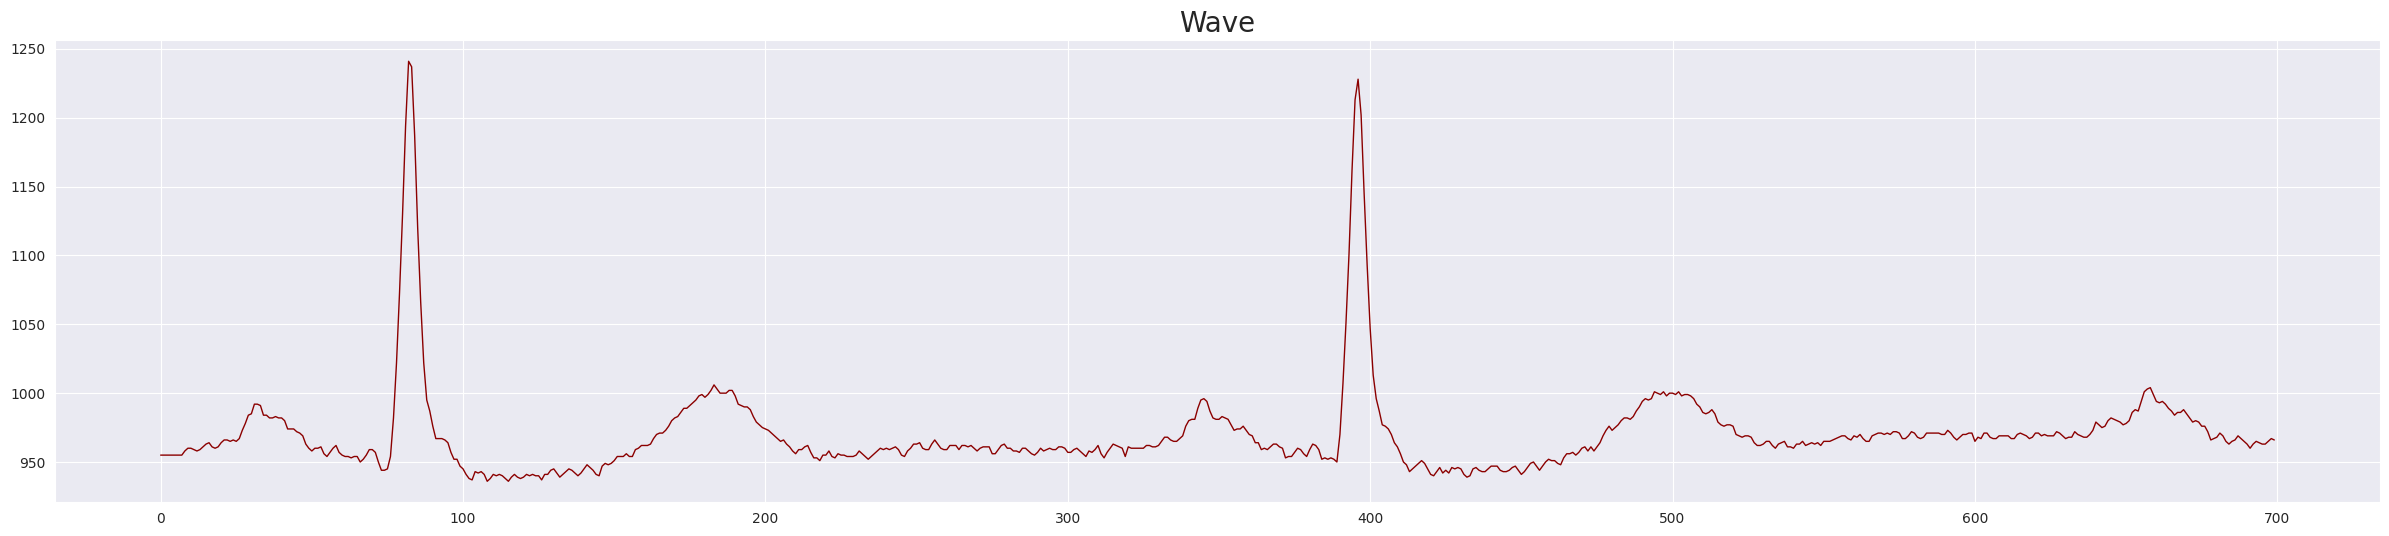

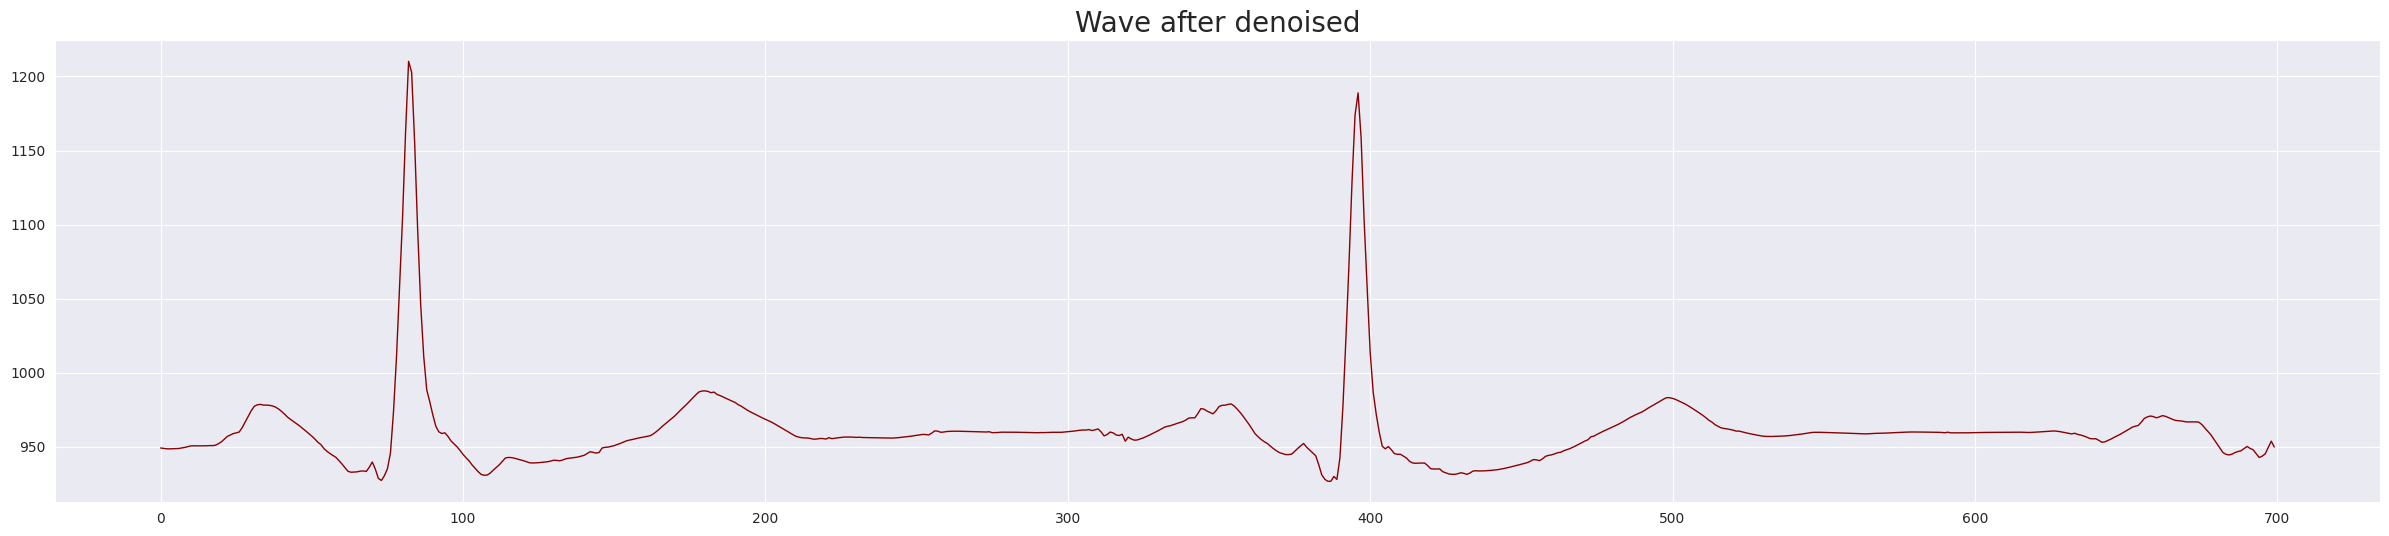

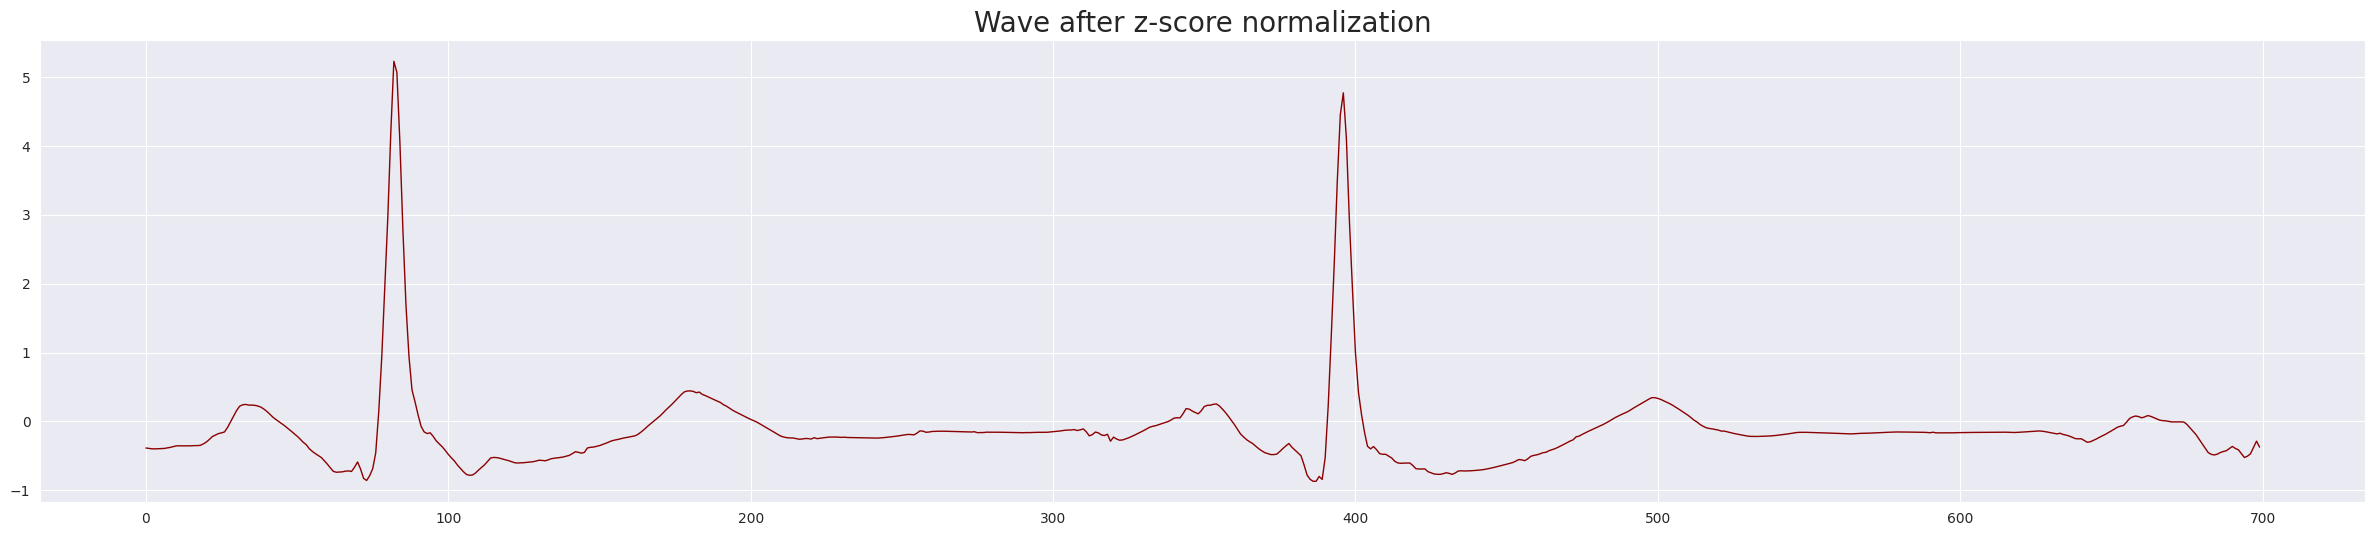

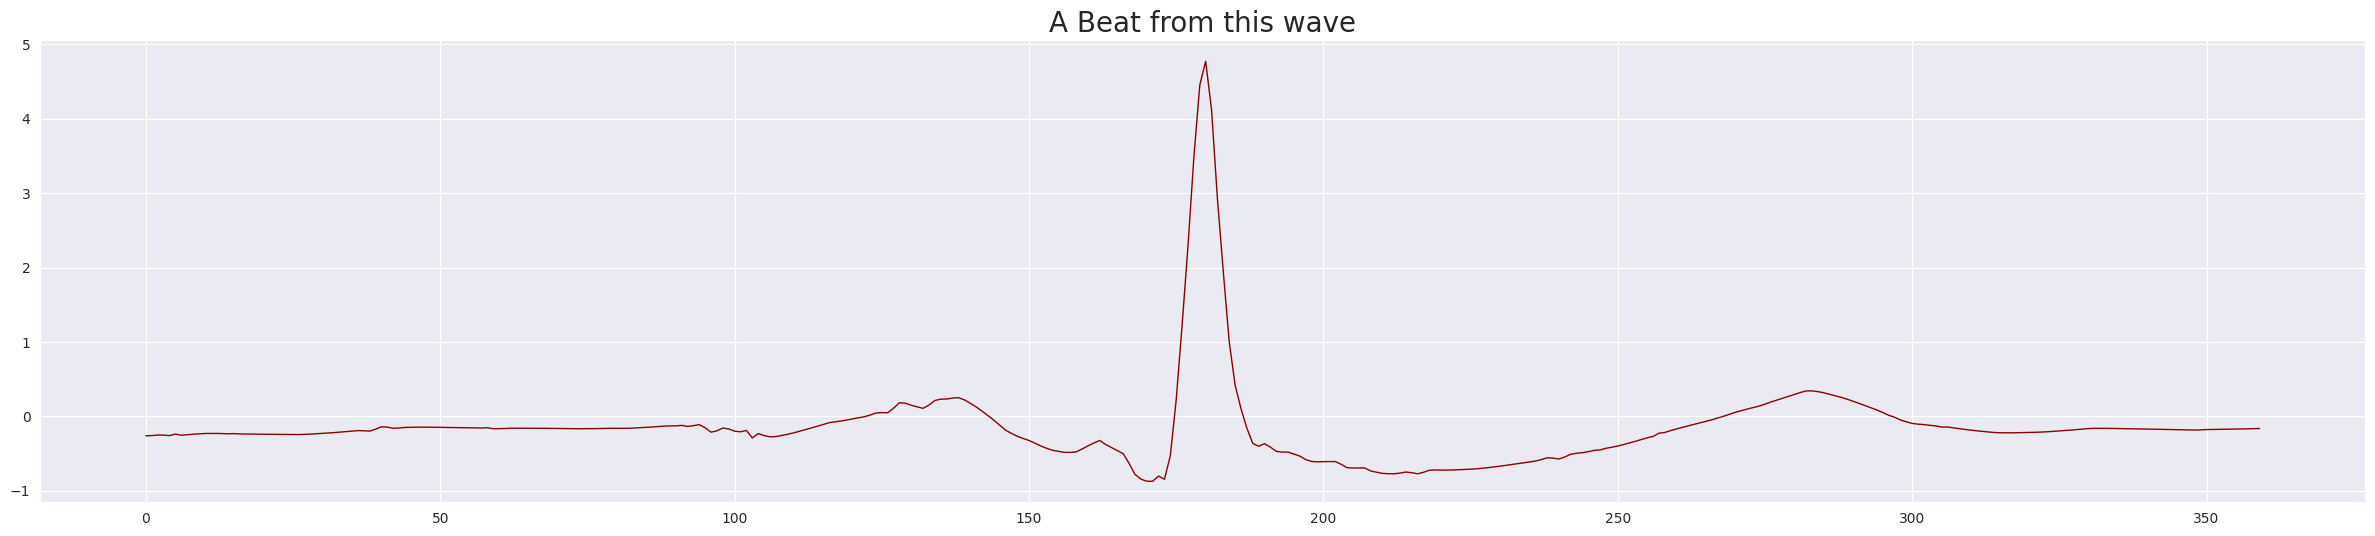

(100012, 360) (100012,)


In [ ]:
!pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style('darkgrid')

for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title("Wave", fontsize=20)
        plt.plot(signals[0:700], color='darkred')
        plt.show()

    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title("Wave after denoised", fontsize=20)
        plt.plot(signals[0:700], color='darkred')
        plt.show()

    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title("Wave after z-score normalization", fontsize=20)
        plt.plot(signals[0:700], color='darkred')
        plt.show()

    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     # REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat
                    if r is 1 and not example_beat_printed:
                        plt.title("A Beat from this wave", fontsize=20)
                        plt.plot(beat, color='darkred')
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

In [ ]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])

print(np.shape(X))

(100012, 361)


0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


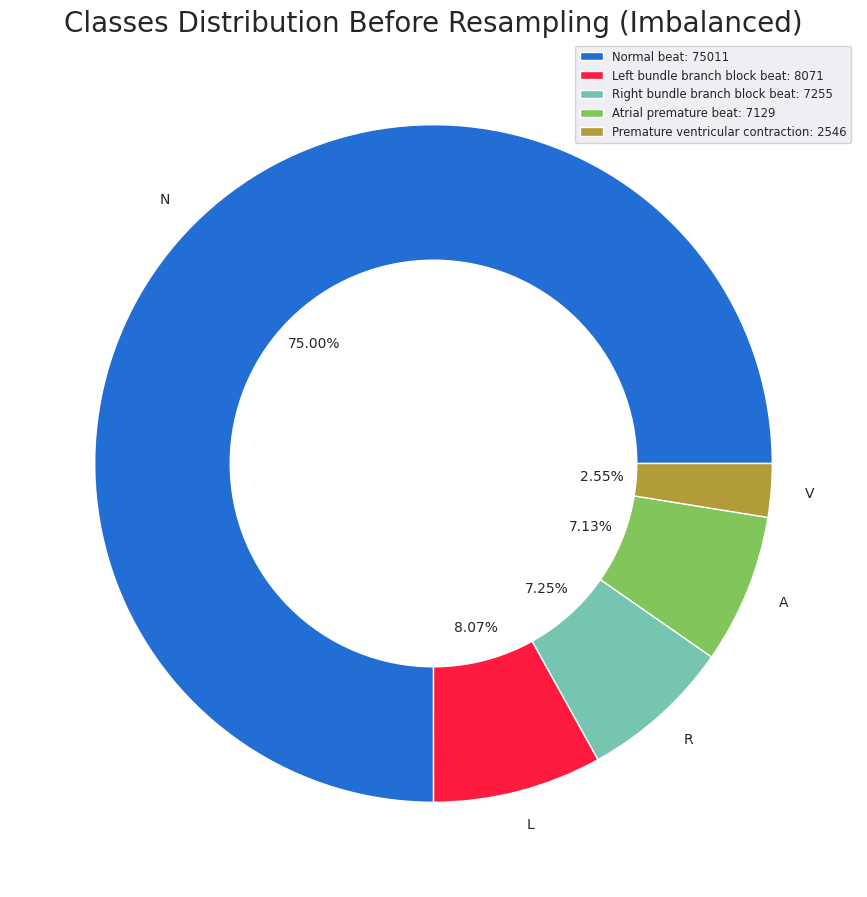

In [ ]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)

plt.figure(figsize=(20,11))
my_circle=plt.Circle( (0,0), 0.6, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['#226ed4','#ff1b40','#76c5b0','#82c55a','#b29b39'], autopct='%1.2f%%', pctdistance=0.5, labeldistance=1.1)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Classes Distribution Before Resampling (Imbalanced)', fontsize=20)

class_labels = ['Normal beat', 'Left bundle branch block beat', 'Right bundle branch block beat', 'Atrial premature beat', 'Premature ventricular contraction']
legend_labels = [f'{label}: {count}' for label, count in zip(class_labels, per_class)]
plt.legend(legend_labels, loc='best', fontsize='small')

plt.show()

A method called **resampling**, which adjusts the number of majority and minority instances, is usually used to **solve the imbalance in training data**. Although resampling can **eliminate imbalances**, it may cause data complexity that deteriorates classification accuracy:

In [ ]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 360, dtype: int64


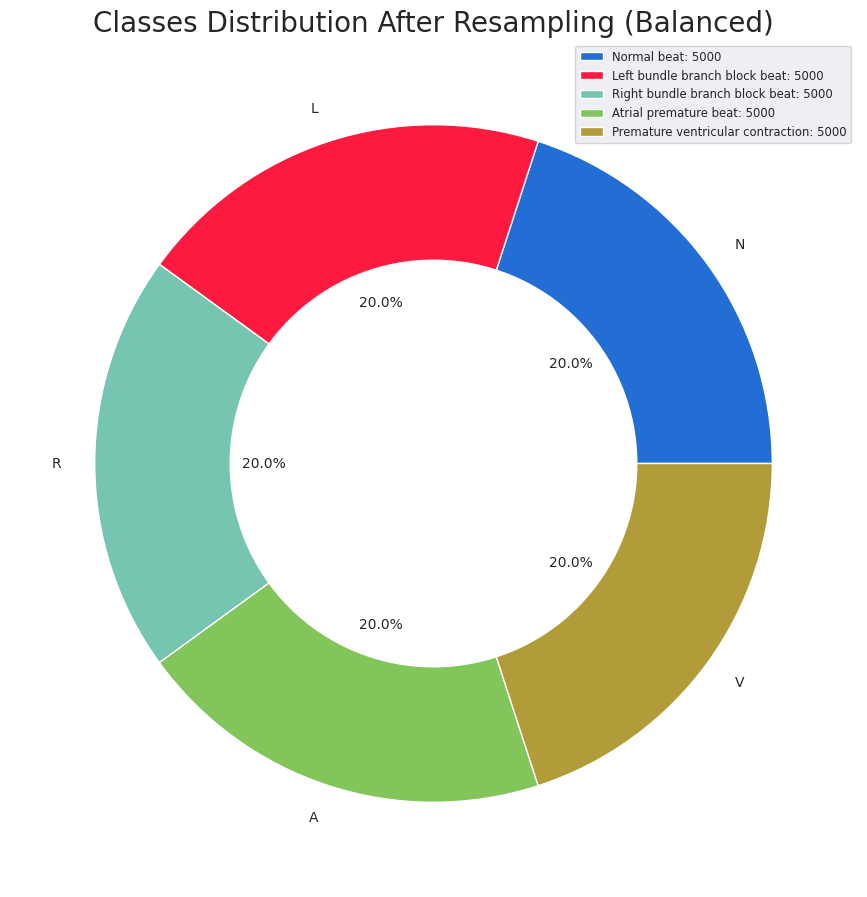

In [ ]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)

plt.figure(figsize=(20,11))
my_circle=plt.Circle( (0,0), 0.6, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['#226ed4','#ff1b40','#76c5b0','#82c55a','#b29b39'], autopct='%1.1f%%', pctdistance=0.5, labeldistance=1.1)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Classes Distribution After Resampling (Balanced)', fontsize=20)

class_labels = ['Normal beat', 'Left bundle branch block beat', 'Right bundle branch block beat', 'Atrial premature beat', 'Premature ventricular contraction']
legend_labels = [f'{label}: {count}' for label, count in zip(class_labels, per_class)]
plt.legend(legend_labels, loc='best', fontsize='small')

plt.show()

In [ ]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [ ]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [ ]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


In [ ]:
# Define a function that builds your model
def create_model(learning_rate=0.001, epochs=10, optimizer='adam', batch_size=36, filters=16, kernel_size=13, dropout=0.5, activation='relu', l2_regularization=0.0001, pool_size=2, strides=1):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, input_shape=(360, 1)))
    model.add(AvgPool1D(pool_size=pool_size, strides=2))
    model.add(Conv1D(filters=filters*2, kernel_size=kernel_size+2, padding='same', activation=activation))
    model.add(AvgPool1D(pool_size=pool_size, strides=2))
    model.add(Conv1D(filters=filters*4, kernel_size=kernel_size+4, padding='same', activation=activation))
    model.add(AvgPool1D(pool_size=pool_size, strides=2))
    model.add(Conv1D(filters=filters*8, kernel_size=kernel_size+6, padding='same', activation=activation))
    model.add(AvgPool1D(pool_size=pool_size, strides=2))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(35, kernel_regularizer=l2(l2_regularization), bias_regularizer=l2(l2_regularization), activation=activation))
    model.add(Dense(5, kernel_regularizer=l2(l2_regularization), bias_regularizer=l2(l2_regularization), activation=activation))
    model.add(Softmax())

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Wrap your Keras model with the KerasClassifier wrapper:
keras_model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the hyperparameters and their possible values to search over
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [12, 16, 24, 32, 36, 48, 60, 64, 128],
    'epochs': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'l2_regularization': [0.0001, 0.001, 0.01],
    'filters': [16, 32, 64, 128, 256],
    'kernel_size': [13, 15, 17, 19, 21],
    'dropout': [0.3, 0.5, 0.7],
    'activation': ['relu', 'sigmoid'],
    'pool_size': [2, 3, 4],
    'strides': [1, 2, 3]
}

# Create the GridSearchCV instance
grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the GridSearchCV instance to your data
grid_result = grid_search.fit(train_x, train_y)

# Print the best parameters found
print("Best Parameters: ", grid_result.best_params_)
print("Best Score: ", grid_result.best_score_)
